In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import copy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def print_results(predictions, labels, name):
    print("{}: {}".format(name, (predictions == labels).sum() / float(len(labels))))

def pad_zeros(input_vector, output_size):
    pad = np.zeros(output_size - input_vector.shape[0])
    return np.append(input_vector, pad)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def graph_to_degree_hist(G):
    degree_hist = np.array(nx.degree_histogram(G))
    degree_hist_padded = pad_zeros(degree_hist, nx.number_of_nodes(G))
    return degree_hist_padded

def plot_degree_histograms(data, labels, prefix=""):
    classes = sorted(list(set(labels)))
    num_classes = len(classes)
    labels = np.array(labels)
    
    f, axarr = plt.subplots(num_classes, sharex=True, sharey=True)
    f.suptitle("{}: Average Node Degree Histogram".format(prefix))
    
    for counter, class_category in enumerate(classes):
        idx = np.where(labels == class_category)
        X = data[idx]
        mean_hist = np.mean(np.array(X), axis=0)
        axarr[counter].bar(np.arange(data.shape[1]), mean_hist, label="p: "+class_category)
        
    f.subplots_adjust(hspace=0)
    for ax in axarr:
        ax.label_outer()
        ax.legend()
        
def visualization(data, labels, method="tSNE"):
    if method == "tSNE":
        viz = TSNE(n_components=2, random_state=0)
    elif method == "PCA":
        viz = PCA(n_components=2)
    data_2d = viz.fit_transform(data)
    label_classes = np.unique(labels).tolist()
    
    plt.figure(figsize=(6, 5))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
    for i, c in zip(label_classes, colors):
        plt.scatter(data_2d[labels == i, 0], data_2d[labels == i, 1], c=c, label=i)
    plt.title("{} visualization of graph classes".format(method))
    plt.legend()

def load_data(train_path, test_path):
    train_list = [f for f in os.listdir(train_path) if not f.startswith('.')]
    test_list = [f for f in os.listdir(test_path) if not f.startswith('.')]
    train_list.sort()
    test_list.sort()

    graphs_train = []
    graphs_test = []
    labels_train = []
    labels_test = []

    for filename in train_list:
        graphs_train.append(nx.read_adjlist(train_path+filename))
        labels_train.append(filename.split("_")[2][:3])

    for filename in test_list:
        graphs_test.append(nx.read_adjlist(test_path+filename))
        labels_test.append(filename.split("_")[2][:3])

    return graphs_train, graphs_test, labels_train, labels_test

In [2]:
# load data
dataset_path = "test_1/"
train_path = "./data/"+dataset_path+"train/"
test_path = "./data/"+dataset_path+"test/"
graphs_train, graphs_test, labels_train, labels_test = load_data(train_path, test_path)

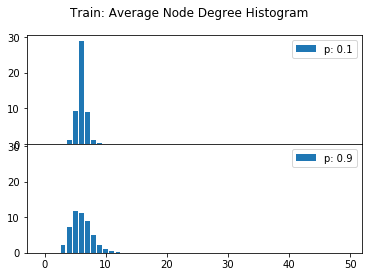

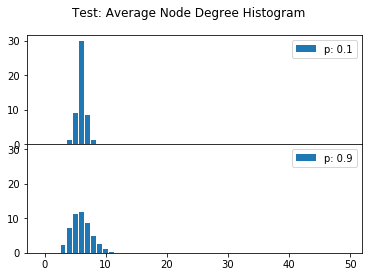

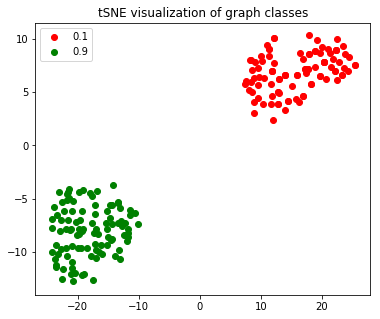

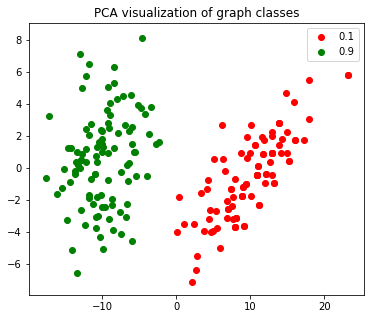

In [3]:
# feature engineering - node degree
X_train = []
X_test = []

num_features = 50

for graph in graphs_train:
    
    hist_train = graph_to_degree_hist(graph)
    X_train.append(hist_train)
    
for graph in graphs_test:
    hist_test = graph_to_degree_hist(graph)
    X_test.append(hist_test)

# prepare data for training
train_X = np.array(X_train).reshape(-1, num_features) # number of features
test_X = np.array(X_test).reshape(-1, num_features) 
train_labels = np.array(labels_train)
test_labels = np.array(labels_test)
train_X, train_labels = unison_shuffled_copies(train_X, train_labels)
test_X, test_labels = unison_shuffled_copies(test_X, test_labels)

# plot histogram and 2-D visualizations
plot_degree_histograms(train_X, train_labels, "Train")
plot_degree_histograms(test_X, test_labels, "Test")
visualization(train_X, train_labels, method="tSNE")
visualization(train_X, train_labels, method="PCA")

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

classifiers = {
    "svm": SVC()
}

parameters_search = {
    "svm": {'kernel':['rbf'], 'C':[0.1, 1, 5, 10]}
}

In [5]:
# select model
model = classifiers["svm"]
parameters = parameters_search["svm"]
clf = GridSearchCV(model, parameters)

# Training session 1
print(">>> no PCA")
clf.fit(train_X, train_labels)
train_predictions = clf.predict(train_X).reshape(-1,1)
test_predictions = clf.predict(test_X).reshape(-1,1)
print_results(np.ravel(train_predictions), train_labels, "Train Accuracy")
print_results(np.ravel(test_predictions), test_labels, "Test Accuracy")
print("best score: {} | best params: {}".format(clf.best_score_, clf.best_params_))

>>> no PCA
Train Accuracy: 1.0
Test Accuracy: 1.0
best score: 1.0 | best params: {'C': 1, 'kernel': 'rbf'}
